
# Project: Investigate Showing Up to Medical Appoaintments

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this notebook, we will be invistagting the factors that affect the show up rate for medical appointments in Brazil. We will be answering few questions including:
1. Is there a difference in show up rate between male and female patients?
2. Is there a difference in show up rate between patients with or without a scholarship?
3. Did patients who received an SMS reminder showed higher show up rate?
4. Are patients with handicaps more or less likely to show up to their appointments?
5. Do patients form certain neighbourhoods show up to thier appoainments more often that others?
6. Does the age of the patient affect the show up rate?

To start the analysis, we will need to import the following libraries:

In [11]:
# import librariries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# to show multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<a id='wrangling'></a>
## Data Wrangling


### Load Data and General Properties

In [12]:
# upload data 
ns_df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
ns_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Find out the number of records and features

In [13]:
# assess the data
ns_df.shape

(110527, 14)

Check the data types of the feature

In [14]:
# check data types
ns_df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

Check for missing data

In [15]:
# check for missing data
ns_df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

Chech for duplicate data

In [16]:
# check for duplicated raws
ns_df.duplicated().sum()

0

In [17]:
print('Number of patients: ' , ns_df['PatientId'].nunique(), 
      '. Number of appointments: ', ns_df['AppointmentID'].nunique())

Number of patients:  62299 . Number of appointments:  110527


Find out the basic stat for the features

In [18]:
ns_df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


The data set has 14 columns (features) and 110,527 raw (appointment) for 62,299 patients. There are no duplicated raws or missing values in the dataset. However, the dataset needs to be cleaned for the following problems:
1. Column names are inconsistenant and have typos, they will be changed for to make analysis easier.
2. Data type of two date features (ScheduledDay, AppointmentDay) is string, which need to be changed to datetime be able to perform downstream analysis.
3. Data type for patient ID is a float, which needs to be changed to int.
4. Minimum age is -1 which is incorrect.
5. No-show data (Yes,No) will be changed to (0,1) to make the analysis easier.
6. Change Gender values to (0,1) for convenience.

### Data Cleaning 

1. Column names

In [19]:
ns_df.rename(columns = {'PatientId' : 'PatientID',
                        'Hipertension' : 'Hypertension',
                        'Handcap': 'Handicap',
                        'SMS_received' : 'SMSReceived',
                        'No-show' : 'NoShow'}, inplace = True)

2. Data type change (datetime)

In [20]:
ns_df['ScheduledDay'] = pd.to_datetime(ns_df['ScheduledDay'])
ns_df['AppointmentDay'] = pd.to_datetime(ns_df['AppointmentDay'])

3. Data type change (int)

In [21]:
ns_df['PatientID'] = ns_df['PatientID'].astype(int)

In [22]:
ns_df.dtypes

PatientID                       int64
AppointmentID                   int64
Gender                         object
ScheduledDay      datetime64[ns, UTC]
AppointmentDay    datetime64[ns, UTC]
Age                             int64
Neighbourhood                  object
Scholarship                     int64
Hypertension                    int64
Diabetes                        int64
Alcoholism                      int64
Handicap                        int64
SMSReceived                     int64
NoShow                         object
dtype: object

In [23]:
ns_df.head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
0,29872499824296,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No


4. Age range

In [24]:
# Check the number of patients who's age is less than 0
ns_df.query('Age < 0')

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
99832,465943158731293,5775010,F,2016-06-06 08:58:13+00:00,2016-06-06 00:00:00+00:00,-1,ROMÃO,0,0,0,0,0,0,No


Given that there is only one patient with age -1, this is clearly a typo, so we can delete this row.

In [25]:
ns_df = ns_df[ns_df.Age >= 0]

In [26]:
ns_df.Age.describe()

count    110526.000000
mean         37.089219
std          23.110026
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

5. Encoding NoShow data

    0 = Did not show up to appointment

    1 = Showed up to appointment

In [27]:
ns_df['NoShow'].replace("No", 1,inplace=True)
ns_df['NoShow'].replace("Yes", 0,inplace=True)

In [28]:
ns_df.NoShow.describe()

count    110526.000000
mean          0.798066
std           0.401445
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: NoShow, dtype: float64

6. Change the values of Gender column

    0 = Male
    
    1 = Female

In [29]:
# change the values of the feature to (0,1) for easier analysis
ns_df['Gender'].replace("F", 1,inplace=True)
ns_df['Gender'].replace("M", 0,inplace=True)

<a id='eda'></a>
## Exploratory Data Analysis

In [30]:
print('Number of appoaintments where the patients showed up is', 
      sum(ns_df['NoShow'] == 1),
      '(%', round(sum(ns_df['NoShow'] == 1)/ns_df.shape[0] * 100, 1),').'
      'Number of appoaintments where the patients did not show up is', 
      sum(ns_df['NoShow'] == 0),
     '(%', round(sum(ns_df['NoShow'] == 0)/ns_df.shape[0] * 100, 1),').')

Number of appoaintments where the patients showed up is 88207 (% 79.8 ).Number of appoaintments where the patients did not show up is 22319 (% 20.2 ).


We will use the following function for the analysis of boolean variables. 

In [31]:
# function for the analysis and visualization of boolean variables
labels = []

def PlotBoolean(col):
    # calculate the vailables
    showed_one = sum((ns_df[col] == 1) & (ns_df['NoShow'] == 1))
    showed_zero = sum((ns_df[col] == 0) & (ns_df['NoShow'] == 1))

    total_one = sum(ns_df[col] == 1) 
    total_zero = sum(ns_df[col] == 0) 

    # Create charts 
    plt.figure(figsize = (12,4))

    xcor = [1,2]
    hights = [round(showed_one/total_one, 3), round(showed_zero/total_zero, 3)]

    plt.subplot(121)
    plt.pie(ns_df[col].value_counts(), labels = labels, autopct='%1.0f%%')
    plt.title('Percentage of Total Patients by {}'.format(col))

    plt.subplot(122)
    plt.bar(xcor, hights, tick_label = labels )
    plt.grid(True, axis='y')
    plt.ylim(0,1)
    plt.title('Ratio of Patients Who Whowed up by {}'.format(col))
    plt.xlabel(col)
    plt.ylabel('Ratio of patients who showed up')

    plt.suptitle(col);

### Is there a difference in show up rate between male and female patients?

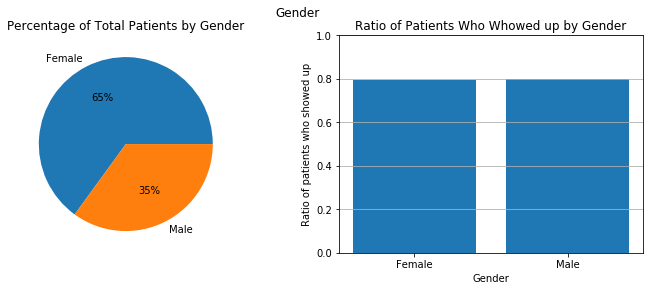

In [32]:
labels = ['Female', 'Male']
PlotBoolean('Gender')

From the charts above, we can se that overall the number of female patients is higher the males. However, that did not affect the show up rate as 79.6% of female patients showed up compared to 80% of male patients.

### Is there a difference in show up rate between patients with or without a scholarship?

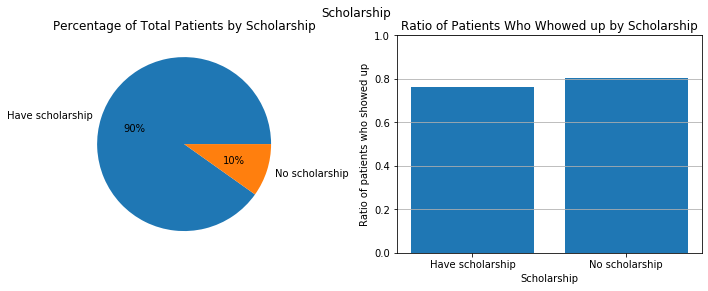

In [33]:
labels = ['Have scholarship', 'No scholarship']
PlotBoolean('Scholarship')

Although the majority of patients have scholarships, patients with no scholarship showed slightly higher rate of showing up (80%) compared to patients with scholardships (76%).

### Did patients who received an SMS reminder showed higher show up rate?

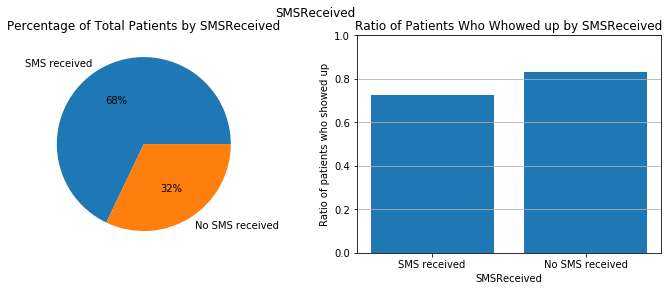

In [34]:
labels = ['SMS received', 'No SMS received']
PlotBoolean('SMSReceived')

We can see from the figures above that the majority of patients received an SMS reminder, however, patients who did  not receive an SMS reminder showed higher show up rates (83%) compareed to those who did receive a reminder (72%). 

### Are patients with handicaps more or less likely to show up to their appointments?

In [35]:
handinum = list(ns_df.Handicap.unique())
totals=[]
ratios = []

for n in range(0,5):
    total = sum(ns_df['Handicap'] == n)
    show = sum((ns_df['Handicap'] == n) & (ns_df['NoShow'] == 1))
    ratio = round(show/total, 3)
    totals.append(total)
    ratios.append(ratio)

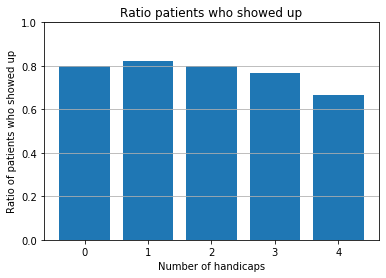

In [36]:
# Create a bar chart with proper labels

plt.bar(handinum, ratios )
plt.grid(True, axis='y')
plt.ylim(0,1)
plt.title('Ratio patients who showed up')
plt.xlabel('Number of handicaps')
plt.ylabel('Ratio of patients who showed up');

Having hanicaps does not seem to affect the rate of show up if the patient has three handicaps or less (show up percentage ranging from 77% to 82%). However, patients with 4 handicaps showed lower show up rate (66.7%).

### Do patients form certain neighbourhoods show up to thier appoainments more often that others?

In [37]:
# create 3 lists (names, totals, ratios)
#names of the neighbourhoods
nb_list = list(ns_df.Neighbourhood.unique())

# other lists
totals = []
ratios = []

for nb in nb_list:
    total = sum(ns_df['Neighbourhood'] == nb)
    show = sum((ns_df['Neighbourhood'] == nb) & (ns_df['NoShow'] == 1))
    ratio = show/total
    totals.append(total)
    ratios.append(ratio)

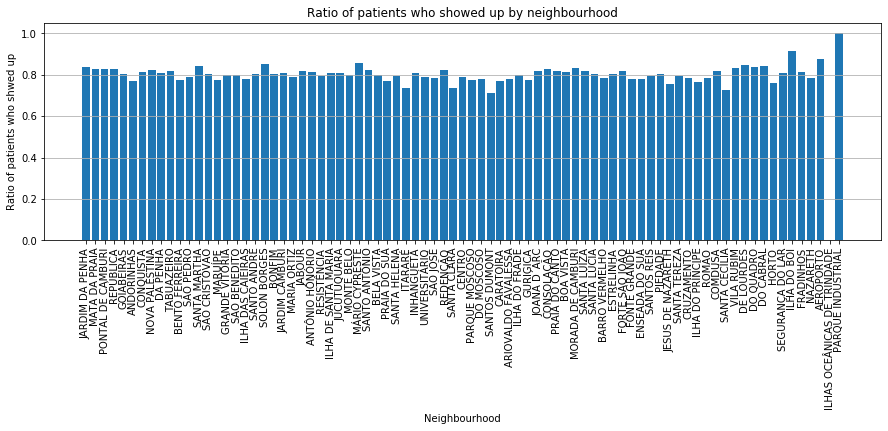

In [38]:
# Create a bar chart with proper labels
xcor = np.arange(len(nb_list))


plt.figure(figsize=(15,4))

plt.bar(xcor, ratios, tick_label = nb_list)
plt.title('Ratio of patients who showed up by neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Ratio of patients who shwed up')
plt.ylim=(0,1)
plt.grid(True, axis='y')

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='center');

From the figure above, we can see that for the majority of the patients the neighbourhood they live in does not play a major role in the rate/likelyhood (70-85%) of them to show up for their appointments, except for two neighbourhoods showed different results with 0% and 100% show up rate (ILHAS OCEÂNICAS DE TRINDADE and PARQUE INDUSTRIAL, respectively). Therefre, we will check the number of patients for further investigation.

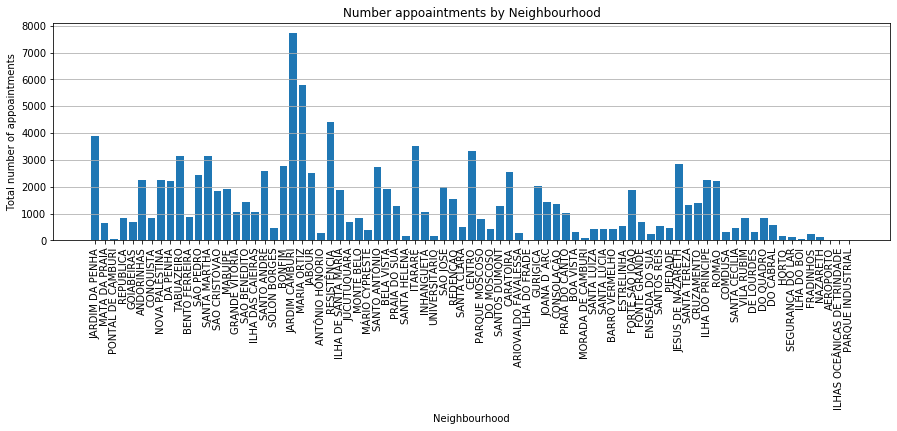

In [39]:
# Create a bar chart with proper labels
xcor = np.arange(len(nb_list))


plt.figure(figsize=(15,4))

plt.bar(xcor, totals, tick_label = nb_list)
plt.title('Number appoaintments by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Total number of appoaintments')
plt.ylim=(0,1)
plt.grid(True, axis='y')

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='center');

The number of patients living in these two neighbourhoods (ILHAS OCEÂNICAS DE TRINDADE and PARQUE INDUSTRIAL) are two and one patients, respectively. Therefore, it is hard to draw a conclusion from this limmeted data.

### Does the age of the patient affect the show up rate?

In [40]:
df_age_ratio = ns_df[ns_df['NoShow'] == 1].groupby(['Age']).size()/ns_df.groupby(['Age']).size()

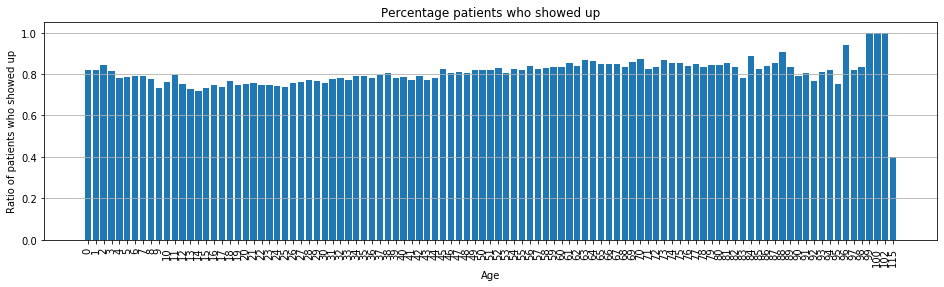

In [41]:
# Create a bar chart with proper labels
xcor = list(range(0,len(df_age_ratio)))
hights = df_age_ratio

plt.figure(figsize=(16,4))
plt.bar(xcor, hights, tick_label = np.sort(ns_df.Age.unique()))
plt.ylim=(0,1)
plt.xlim=(0,115)
plt.grid(True, axis='y')
plt.title('Percentage patients who showed up')
plt.xlabel('Age')
plt.ylabel('Ratio of patients who showed up')

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='center');

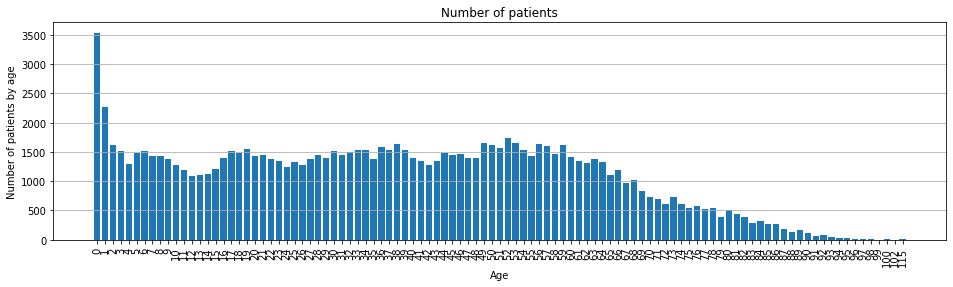

In [42]:
# Create a bar chart with proper labels
xcor = list(range(0,len(df_age_ratio)))
hights = ns_df.groupby(['Age']).size()

plt.figure(figsize=(16,4))
plt.bar(xcor, hights, tick_label = np.sort(ns_df.Age.unique()))
plt.ylim=(0,1)
plt.xlim=(0,115)
plt.grid(True, axis='y')
plt.title('Number of patients')
plt.xlabel('Age')
plt.ylabel('Number of patients by age')

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='center');

Over all the age of the patient does not seem to affect the show up rate, form the figures above we can see that the ratio of showing up does not vary much between ages except for patients above 90 years old. However, it is difficult to draw colculsions from these limited data as the number of patients in this age group is very low, as we can see in the second figure.

<a id='conclusions'></a>
## Conclusions



Form the analysis performed above on several independant variable (gender, scholarship, age, neighbourhood, handicap, and SMS receiving), we can see that the gender, having a scholarship, age, and neighbourhood the patient lives in did not affect the show up rates. While, having handicaps and recieving an SMS reminder seems to affect the show up rates. Against expectations, the analysis showed that people who did not receive an SMS remainder had higher show up rate. Further analysis is required to invistgate the resoans behinde that and any other cofactors that may have an impact. Patients with more than 3 handicaps showed lower show up rates, which could be explained by the difficalty they may face in getting to the clinic. Definite conclusions cannot be drawn for this limited analysis.